In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [3]:
Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

##Adding every plot coordinate
#GA:
allplots_fc = 'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/GA_allplots_NEW.csv'

##Virginia:
# allplots_fc= 'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Coordinates and biomass/va_allspecies2.csv'

xin_fc =  'C:/Users/arj26323/Documents/Xin data/Biomass_Shapefile/Biomass.shp'

fc_all = geemap.csv_to_ee(allplots_fc, latitude = "Latitude", longitude = "Longitude")
fc_test = pd.read_csv(allplots_fc)

# fc_all = geemap.shp_to_ee(allplots_fc, latitude = "Latitude", longitude = "Longitude")

In [4]:
# fc_all
# Function to add latitude and longitude as properties
def add_lat_lon(feature):
    coords = feature.geometry().coordinates()
    return feature.set({
        'Latitude': coords.get(1),  # Extract latitude
        'Longitude': coords.get(0)   # Extract longitude
    })

# Apply function to all features in fc_all
# fc_all = fc_all.map(add_lat_lon)

In [5]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.

#IS THIS SAME BETWEEN SENSORS: https://github.com/giswqs/geemap/discussions/672

def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)


In [6]:
#12/08/22 - adding CALIBRATED FLATS
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.2) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

##ADDING NDVI (for min/max variables)
def addL5ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addL8ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

In [7]:
##Pixel extraction functions - addDate for dateless images/collections
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('imagedate').toInt())

##For Landsat images:
def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 30,
        tileScale = 16 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)
    )
    return feature


In [8]:
#Datasets
ls5_collect = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL5)
ls7_collect = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL7)
ls8_collect = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)
ls9_collect = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)

#Merge
ultra_col = ls8_collect.merge(ls5_collect).merge(ls7_collect).merge(ls9_collect).select('flats')

In [10]:
Map.addLayer(fc_all)
# Map

In [9]:
#Uncomment to run extraction

# def rasterExtraction(image, fc_subset):
#     return image.sampleRegions(
#         collection=fc_subset,  # Use the subset of locations
#         scale=30,
#         tileScale=8  # Adjust tile scale for performance
#     ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))

# out_dir = os.path.expanduser('~/Documents/Xin data/Virginia')

# # Split locations into batches of 100
# batch_size = 100
# fc_list = fc_all.toList(fc_all.size())  # Convert to list
# num_features = fc_all.size().getInfo()

# # Calculate the number of batches without math.ceil()
# num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

# years = range(1984, 2020)

# for year in years:
#     for batch in range(num_batches):
#         # Subset locations for this batch
#         fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

#         print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

#         # Filter Landsat images for the year
#         subset = ultra_col.filterDate(f"{year}-01-01", f"{year}-12-31")

#         # Fix: Use a lambda function to pass `fc_subset` properly
#         extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

#         fc_dict = extracted_features.getInfo()
#         features = [feature['properties'] for feature in fc_dict['features']]
#         df = pd.DataFrame(features)
#         df['date'] = pd.to_datetime(df['date'])

#         # Save file in the specified directory
#         filename = os.path.join(out_dir, f"VAlandsatflats_{year}_batch{batch + 1}.csv")
#         df.to_csv(filename, index=False)
#         print(f"Saved {filename}")

# print("All batches processed!")


Processing 1984, Batch 1/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch1.csv
Processing 1984, Batch 2/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch2.csv
Processing 1984, Batch 3/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch3.csv
Processing 1984, Batch 4/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch4.csv
Processing 1984, Batch 5/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch5.csv
Processing 1984, Batch 6/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch6.csv
Processing 1984, Batch 7/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch7.csv
Processing 1984, Batch 8/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch8.csv
Processing 1984, Batch 9/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlan

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch72.csv
Processing 1984, Batch 73/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch73.csv
Processing 1984, Batch 74/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch74.csv
Processing 1984, Batch 75/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch75.csv
Processing 1984, Batch 76/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch76.csv
Processing 1984, Batch 77/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1984_batch77.csv
Processing 1985, Batch 1/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch1.csv
Processing 1985, Batch 2/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch2.csv
Processing 1985, Batch 3/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch66.csv
Processing 1985, Batch 67/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch67.csv
Processing 1985, Batch 68/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch68.csv
Processing 1985, Batch 69/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch69.csv
Processing 1985, Batch 70/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch70.csv
Processing 1985, Batch 71/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch71.csv
Processing 1985, Batch 72/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch72.csv
Processing 1985, Batch 73/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_batch73.csv
Processing 1985, Batch 74/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1985_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch60.csv
Processing 1986, Batch 61/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch61.csv
Processing 1986, Batch 62/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch62.csv
Processing 1986, Batch 63/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch63.csv
Processing 1986, Batch 64/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch64.csv
Processing 1986, Batch 65/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch65.csv
Processing 1986, Batch 66/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch66.csv
Processing 1986, Batch 67/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_batch67.csv
Processing 1986, Batch 68/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1986_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch54.csv
Processing 1987, Batch 55/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch55.csv
Processing 1987, Batch 56/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch56.csv
Processing 1987, Batch 57/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch57.csv
Processing 1987, Batch 58/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch58.csv
Processing 1987, Batch 59/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch59.csv
Processing 1987, Batch 60/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch60.csv
Processing 1987, Batch 61/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_batch61.csv
Processing 1987, Batch 62/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1987_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch48.csv
Processing 1988, Batch 49/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch49.csv
Processing 1988, Batch 50/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch50.csv
Processing 1988, Batch 51/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch51.csv
Processing 1988, Batch 52/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch52.csv
Processing 1988, Batch 53/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch53.csv
Processing 1988, Batch 54/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch54.csv
Processing 1988, Batch 55/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_batch55.csv
Processing 1988, Batch 56/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1988_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch42.csv
Processing 1989, Batch 43/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch43.csv
Processing 1989, Batch 44/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch44.csv
Processing 1989, Batch 45/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch45.csv
Processing 1989, Batch 46/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch46.csv
Processing 1989, Batch 47/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch47.csv
Processing 1989, Batch 48/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch48.csv
Processing 1989, Batch 49/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_batch49.csv
Processing 1989, Batch 50/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1989_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch36.csv
Processing 1990, Batch 37/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch37.csv
Processing 1990, Batch 38/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch38.csv
Processing 1990, Batch 39/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch39.csv
Processing 1990, Batch 40/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch40.csv
Processing 1990, Batch 41/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch41.csv
Processing 1990, Batch 42/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch42.csv
Processing 1990, Batch 43/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_batch43.csv
Processing 1990, Batch 44/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1990_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch30.csv
Processing 1991, Batch 31/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch31.csv
Processing 1991, Batch 32/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch32.csv
Processing 1991, Batch 33/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch33.csv
Processing 1991, Batch 34/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch34.csv
Processing 1991, Batch 35/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch35.csv
Processing 1991, Batch 36/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch36.csv
Processing 1991, Batch 37/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_batch37.csv
Processing 1991, Batch 38/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1991_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch24.csv
Processing 1992, Batch 25/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch25.csv
Processing 1992, Batch 26/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch26.csv
Processing 1992, Batch 27/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch27.csv
Processing 1992, Batch 28/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch28.csv
Processing 1992, Batch 29/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch29.csv
Processing 1992, Batch 30/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch30.csv
Processing 1992, Batch 31/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_batch31.csv
Processing 1992, Batch 32/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1992_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch18.csv
Processing 1993, Batch 19/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch19.csv
Processing 1993, Batch 20/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch20.csv
Processing 1993, Batch 21/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch21.csv
Processing 1993, Batch 22/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch22.csv
Processing 1993, Batch 23/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch23.csv
Processing 1993, Batch 24/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch24.csv
Processing 1993, Batch 25/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_batch25.csv
Processing 1993, Batch 26/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1993_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch12.csv
Processing 1994, Batch 13/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch13.csv
Processing 1994, Batch 14/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch14.csv
Processing 1994, Batch 15/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch15.csv
Processing 1994, Batch 16/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch16.csv
Processing 1994, Batch 17/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch17.csv
Processing 1994, Batch 18/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch18.csv
Processing 1994, Batch 19/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_batch19.csv
Processing 1994, Batch 20/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1994_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch6.csv
Processing 1995, Batch 7/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch7.csv
Processing 1995, Batch 8/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch8.csv
Processing 1995, Batch 9/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch9.csv
Processing 1995, Batch 10/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch10.csv
Processing 1995, Batch 11/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch11.csv
Processing 1995, Batch 12/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch12.csv
Processing 1995, Batch 13/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch13.csv
Processing 1995, Batch 14/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch14

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1995_batch77.csv
Processing 1996, Batch 1/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch1.csv
Processing 1996, Batch 2/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch2.csv
Processing 1996, Batch 3/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch3.csv
Processing 1996, Batch 4/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch4.csv
Processing 1996, Batch 5/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch5.csv
Processing 1996, Batch 6/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch6.csv
Processing 1996, Batch 7/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch7.csv
Processing 1996, Batch 8/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch8.csv
Proc

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch71.csv
Processing 1996, Batch 72/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch72.csv
Processing 1996, Batch 73/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch73.csv
Processing 1996, Batch 74/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch74.csv
Processing 1996, Batch 75/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch75.csv
Processing 1996, Batch 76/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch76.csv
Processing 1996, Batch 77/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1996_batch77.csv
Processing 1997, Batch 1/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch1.csv
Processing 1997, Batch 2/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_bat

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch65.csv
Processing 1997, Batch 66/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch66.csv
Processing 1997, Batch 67/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch67.csv
Processing 1997, Batch 68/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch68.csv
Processing 1997, Batch 69/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch69.csv
Processing 1997, Batch 70/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch70.csv
Processing 1997, Batch 71/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch71.csv
Processing 1997, Batch 72/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_batch72.csv
Processing 1997, Batch 73/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1997_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch59.csv
Processing 1998, Batch 60/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch60.csv
Processing 1998, Batch 61/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch61.csv
Processing 1998, Batch 62/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch62.csv
Processing 1998, Batch 63/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch63.csv
Processing 1998, Batch 64/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch64.csv
Processing 1998, Batch 65/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch65.csv
Processing 1998, Batch 66/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_batch66.csv
Processing 1998, Batch 67/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1998_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch53.csv
Processing 1999, Batch 54/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch54.csv
Processing 1999, Batch 55/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch55.csv
Processing 1999, Batch 56/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch56.csv
Processing 1999, Batch 57/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch57.csv
Processing 1999, Batch 58/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch58.csv
Processing 1999, Batch 59/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch59.csv
Processing 1999, Batch 60/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_batch60.csv
Processing 1999, Batch 61/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_1999_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch47.csv
Processing 2000, Batch 48/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch48.csv
Processing 2000, Batch 49/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch49.csv
Processing 2000, Batch 50/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch50.csv
Processing 2000, Batch 51/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch51.csv
Processing 2000, Batch 52/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch52.csv
Processing 2000, Batch 53/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch53.csv
Processing 2000, Batch 54/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_batch54.csv
Processing 2000, Batch 55/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2000_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch41.csv
Processing 2001, Batch 42/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch42.csv
Processing 2001, Batch 43/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch43.csv
Processing 2001, Batch 44/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch44.csv
Processing 2001, Batch 45/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch45.csv
Processing 2001, Batch 46/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch46.csv
Processing 2001, Batch 47/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch47.csv
Processing 2001, Batch 48/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_batch48.csv
Processing 2001, Batch 49/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2001_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch35.csv
Processing 2002, Batch 36/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch36.csv
Processing 2002, Batch 37/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch37.csv
Processing 2002, Batch 38/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch38.csv
Processing 2002, Batch 39/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch39.csv
Processing 2002, Batch 40/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch40.csv
Processing 2002, Batch 41/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch41.csv
Processing 2002, Batch 42/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_batch42.csv
Processing 2002, Batch 43/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2002_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch29.csv
Processing 2003, Batch 30/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch30.csv
Processing 2003, Batch 31/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch31.csv
Processing 2003, Batch 32/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch32.csv
Processing 2003, Batch 33/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch33.csv
Processing 2003, Batch 34/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch34.csv
Processing 2003, Batch 35/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch35.csv
Processing 2003, Batch 36/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_batch36.csv
Processing 2003, Batch 37/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2003_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch23.csv
Processing 2004, Batch 24/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch24.csv
Processing 2004, Batch 25/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch25.csv
Processing 2004, Batch 26/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch26.csv
Processing 2004, Batch 27/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch27.csv
Processing 2004, Batch 28/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch28.csv
Processing 2004, Batch 29/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch29.csv
Processing 2004, Batch 30/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_batch30.csv
Processing 2004, Batch 31/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2004_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch17.csv
Processing 2005, Batch 18/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch18.csv
Processing 2005, Batch 19/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch19.csv
Processing 2005, Batch 20/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch20.csv
Processing 2005, Batch 21/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch21.csv
Processing 2005, Batch 22/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch22.csv
Processing 2005, Batch 23/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch23.csv
Processing 2005, Batch 24/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_batch24.csv
Processing 2005, Batch 25/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2005_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch11.csv
Processing 2006, Batch 12/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch12.csv
Processing 2006, Batch 13/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch13.csv
Processing 2006, Batch 14/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch14.csv
Processing 2006, Batch 15/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch15.csv
Processing 2006, Batch 16/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch16.csv
Processing 2006, Batch 17/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch17.csv
Processing 2006, Batch 18/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_batch18.csv
Processing 2006, Batch 19/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2006_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch5.csv
Processing 2007, Batch 6/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch6.csv
Processing 2007, Batch 7/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch7.csv
Processing 2007, Batch 8/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch8.csv
Processing 2007, Batch 9/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch9.csv
Processing 2007, Batch 10/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch10.csv
Processing 2007, Batch 11/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch11.csv
Processing 2007, Batch 12/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch12.csv
Processing 2007, Batch 13/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch13.c

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch76.csv
Processing 2007, Batch 77/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2007_batch77.csv
Processing 2008, Batch 1/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch1.csv
Processing 2008, Batch 2/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch2.csv
Processing 2008, Batch 3/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch3.csv
Processing 2008, Batch 4/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch4.csv
Processing 2008, Batch 5/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch5.csv
Processing 2008, Batch 6/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch6.csv
Processing 2008, Batch 7/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch7.csv
Pr

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch70.csv
Processing 2008, Batch 71/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch71.csv
Processing 2008, Batch 72/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch72.csv
Processing 2008, Batch 73/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch73.csv
Processing 2008, Batch 74/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch74.csv
Processing 2008, Batch 75/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch75.csv
Processing 2008, Batch 76/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch76.csv
Processing 2008, Batch 77/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2008_batch77.csv
Processing 2009, Batch 1/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_b

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch64.csv
Processing 2009, Batch 65/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch65.csv
Processing 2009, Batch 66/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch66.csv
Processing 2009, Batch 67/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch67.csv
Processing 2009, Batch 68/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch68.csv
Processing 2009, Batch 69/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch69.csv
Processing 2009, Batch 70/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch70.csv
Processing 2009, Batch 71/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_batch71.csv
Processing 2009, Batch 72/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2009_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch58.csv
Processing 2010, Batch 59/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch59.csv
Processing 2010, Batch 60/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch60.csv
Processing 2010, Batch 61/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch61.csv
Processing 2010, Batch 62/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch62.csv
Processing 2010, Batch 63/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch63.csv
Processing 2010, Batch 64/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch64.csv
Processing 2010, Batch 65/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_batch65.csv
Processing 2010, Batch 66/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2010_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch52.csv
Processing 2011, Batch 53/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch53.csv
Processing 2011, Batch 54/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch54.csv
Processing 2011, Batch 55/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch55.csv
Processing 2011, Batch 56/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch56.csv
Processing 2011, Batch 57/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch57.csv
Processing 2011, Batch 58/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch58.csv
Processing 2011, Batch 59/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_batch59.csv
Processing 2011, Batch 60/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2011_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch46.csv
Processing 2012, Batch 47/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch47.csv
Processing 2012, Batch 48/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch48.csv
Processing 2012, Batch 49/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch49.csv
Processing 2012, Batch 50/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch50.csv
Processing 2012, Batch 51/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch51.csv
Processing 2012, Batch 52/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch52.csv
Processing 2012, Batch 53/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_batch53.csv
Processing 2012, Batch 54/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2012_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch40.csv
Processing 2013, Batch 41/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch41.csv
Processing 2013, Batch 42/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch42.csv
Processing 2013, Batch 43/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch43.csv
Processing 2013, Batch 44/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch44.csv
Processing 2013, Batch 45/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch45.csv
Processing 2013, Batch 46/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch46.csv
Processing 2013, Batch 47/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_batch47.csv
Processing 2013, Batch 48/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2013_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch34.csv
Processing 2014, Batch 35/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch35.csv
Processing 2014, Batch 36/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch36.csv
Processing 2014, Batch 37/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch37.csv
Processing 2014, Batch 38/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch38.csv
Processing 2014, Batch 39/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch39.csv
Processing 2014, Batch 40/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch40.csv
Processing 2014, Batch 41/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_batch41.csv
Processing 2014, Batch 42/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2014_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch28.csv
Processing 2015, Batch 29/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch29.csv
Processing 2015, Batch 30/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch30.csv
Processing 2015, Batch 31/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch31.csv
Processing 2015, Batch 32/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch32.csv
Processing 2015, Batch 33/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch33.csv
Processing 2015, Batch 34/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch34.csv
Processing 2015, Batch 35/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_batch35.csv
Processing 2015, Batch 36/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2015_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch22.csv
Processing 2016, Batch 23/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch23.csv
Processing 2016, Batch 24/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch24.csv
Processing 2016, Batch 25/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch25.csv
Processing 2016, Batch 26/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch26.csv
Processing 2016, Batch 27/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch27.csv
Processing 2016, Batch 28/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch28.csv
Processing 2016, Batch 29/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_batch29.csv
Processing 2016, Batch 30/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2016_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch16.csv
Processing 2017, Batch 17/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch17.csv
Processing 2017, Batch 18/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch18.csv
Processing 2017, Batch 19/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch19.csv
Processing 2017, Batch 20/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch20.csv
Processing 2017, Batch 21/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch21.csv
Processing 2017, Batch 22/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch22.csv
Processing 2017, Batch 23/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_batch23.csv
Processing 2017, Batch 24/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2017_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch10.csv
Processing 2018, Batch 11/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch11.csv
Processing 2018, Batch 12/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch12.csv
Processing 2018, Batch 13/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch13.csv
Processing 2018, Batch 14/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch14.csv
Processing 2018, Batch 15/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch15.csv
Processing 2018, Batch 16/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch16.csv
Processing 2018, Batch 17/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_batch17.csv
Processing 2018, Batch 18/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2018_

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch4.csv
Processing 2019, Batch 5/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch5.csv
Processing 2019, Batch 6/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch6.csv
Processing 2019, Batch 7/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch7.csv
Processing 2019, Batch 8/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch8.csv
Processing 2019, Batch 9/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch9.csv
Processing 2019, Batch 10/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch10.csv
Processing 2019, Batch 11/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch11.csv
Processing 2019, Batch 12/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch12.csv

Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch75.csv
Processing 2019, Batch 76/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch76.csv
Processing 2019, Batch 77/77...
Saved C:\Users\arj26323/Documents/Xin data/Virginia\VAlandsatflats_2019_batch77.csv
All batches processed!


In [11]:
#PROPORTION OF TIME FLOODED
#Inundation intensity
#Rajneesh

# import glob

# path = r'C:/Users/arj26323/Documents/Xin data/Landsat' 
# all_files = glob.glob(path + "/landsatflats_1984_*")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)

# df

# upd = df[['Latitude', 'Longitude']].drop_duplicates().reset_index()
# upd

# Map.add_points_from_xy(upd, x="Longitude", y="Latitude")
# Map.addLayer(ultra_col.first(),{},'flats')
# Map.addLayer(fc_all,{},'points')
# Map
# fc_all
# Map

index   Latitude  Longitude
0        0  31.538627 -81.422539
1       19  31.536199 -81.296118
2       21  31.436090 -81.339919
3       61  31.518920 -81.228956
4       73  31.451676 -81.365498
..     ...        ...        ...
203  49966  31.435830 -81.341134
204  49985  31.387957 -81.280219
205  49996  31.387957 -81.280220
206  50061  31.351060 -81.333347
207  50080  31.476954 -81.271005

[208 rows x 3 columns]

In [9]:
import glob

# path = r'C:/Users/arj26323/Documents/Xin data/Landsat' 
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)

# df

Date   Latitude  Longitude  Plant_Biomass  Plot  Sample_Size  \
0        10/11/2000  31.538627 -81.422539        516.324     1           23   
1        10/17/2001  31.538627 -81.422539        424.416     1           18   
2        10/16/2002  31.538627 -81.422539        259.784     1           16   
3        10/25/2004  31.538627 -81.422539        436.332     1           18   
4        10/24/2005  31.538627 -81.422539        649.300     1           25   
...             ...        ...        ...            ...   ...          ...   
3983823  10/26/2011  31.477098 -81.270523        286.096     2           11   
3983824  10/14/2012  31.477098 -81.270523        371.072     2           12   
3983825  10/13/2013  31.477098 -81.270523        475.344     2           14   
3983826  10/18/2014  31.477098 -81.270523        446.432     2           17   
3983827  10/24/2015  31.477098 -81.270523        608.608     2           18   

         Site Species_Code  Year  Zone        date     flats  
0           1           A1  2000     1  1984-04-12  0.003720  
1           1           A1  2001     1  1984-04-12  0.003720  
2           1           A1  2002     1  1984-04-12  0.003720  
3           1           A1  2004     1  1984-04-12  0.003720  
4           1           A1  2005     1  1984-04-12  0.003720  
...       ...          ...   ...   ...         ...       ...  
3983823    10           A1  2011     2  2024-12-21  0.004613  
3983824    10           A1  2012     2  2024-12-21  0.004613  
3983825    10           A1  2013     2  2024-12-21  0.004613  
3983826    10           A1  2014     2  2024-12-21  0.004613  
3983827    10           A1  2015     2  2024-12-21  0.004613  

[3983828 rows x 12 columns]

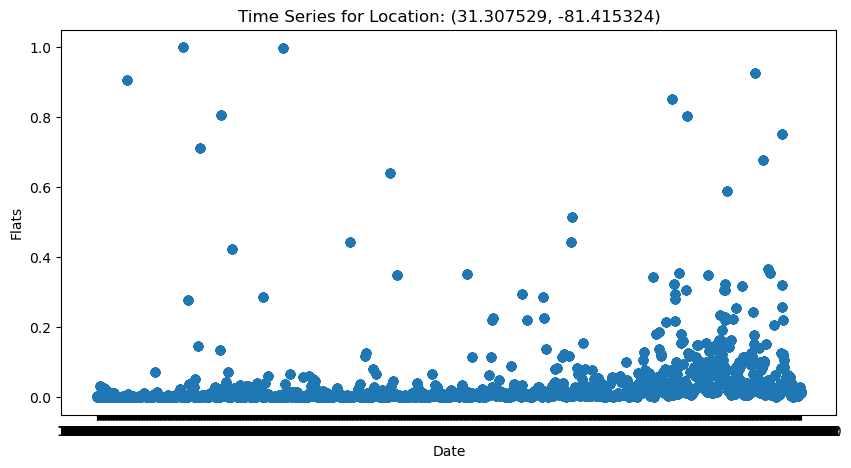

In [10]:
# Group by unique latitude/longitude pairs
grouped = df.groupby(['Latitude', 'Longitude'])

# Select one unique location (e.g., first location in the grouped data)
(lat, lon), location_df = next(iter(grouped))

# Sort by date to ensure proper time series order
location_df = location_df.sort_values('date')

# Plot the time series of 'flats' for this location
plt.figure(figsize=(10, 5))
plt.plot(location_df['date'], location_df['flats'], marker='o', linestyle='')

plt.xlabel("Date")
plt.ylabel("Flats")
plt.title(f"Time Series for Location: ({lat}, {lon})")
plt.show()

In [21]:
location_df['date']

Latitude  Longitude
6   31.352109 -81.333734
84  31.352050 -81.333824

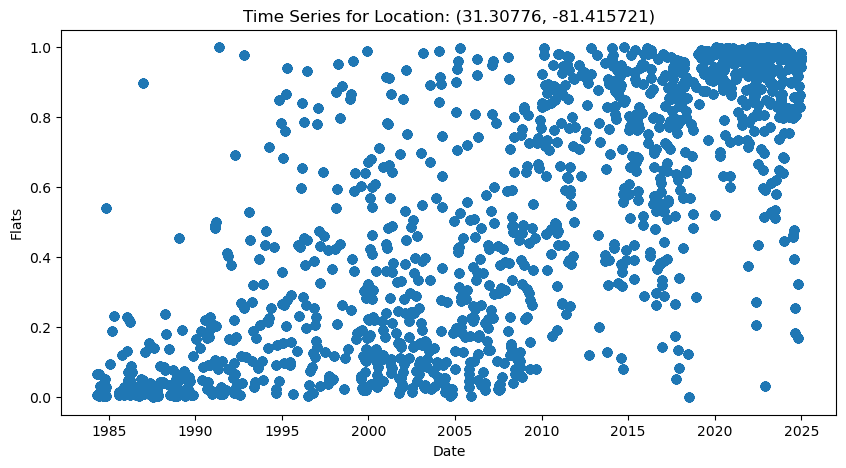

In [24]:
# Get unique latitude/longitude pairs
unique_locations = df[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# Display indexed locations
# print("Available Locations:")
# for i, (lat, lon) in unique_locations.iterrows():
#     print(f"{i}: ({lat}, {lon})")

# Ask user to select a location by index
# selection = int(input("Enter the index of the location you want to plot: "))

# Extract selected location
# lat, lon = unique_locations.iloc[selection]
lat, lon = (31.30776, -81.415721)

# Filter dataframe for the selected location
location_df = df[(df['Latitude'] == lat) & (df['Longitude'] == lon)].sort_values('date')

location_df['date'] = pd.to_datetime(location_df['date'])

# Plot time series for selected location
plt.figure(figsize=(10, 5))
plt.plot(location_df['date'], location_df['flats'], marker='o', linestyle='')

plt.xlabel("Date")
plt.ylabel("Flats")

plt.xticks(rotation=0) # Rotate the x-axis labels by 45 degrees

# fig, ax = plt.subplots()
# fig.autofmt_xdate()

plt.title(f"Time Series for Location: ({lat}, {lon})")
plt.show()

In [12]:
#df.groupby(['Latitude','Longitude']).size()

df_flooding = df.groupby(['Latitude', 'Longitude']).apply(
    lambda g: (g['flats'] >= 0.2).mean()).reset_index(name='Percent_flooding'
                                                     )
df_flooding

Latitude  Longitude  Percent_flooding
0    31.307529 -81.415324          0.039201
1    31.307562 -81.415389          0.039201
2    31.307641 -81.415468          0.039201
3    31.307693 -81.415592          0.721236
4    31.307760 -81.415721          0.721236
..         ...        ...               ...
176  31.539429 -81.422410          0.009724
177  31.539457 -81.422250          0.006415
178  31.539480 -81.422098          0.006415
179  31.539491 -81.421750          0.004831
180  31.539505 -81.421937          0.004831

[181 rows x 3 columns]

In [33]:
# xxx= ee.Image((ultra_col.toList(ultra_col.size())).get(0))

# Map.addLayer(xxx, {}, 'xxx')
# Map


# import os

# out_dir = os.path.expanduser('~/Downloads')
# out_csv = os.path.join(out_dir, 'flood_freq.csv')

# df_flooding.to_csv(out_csv)

dfx = df[df['Date'] == 20151023]

dfy =dfx[dfx['Latitude'] == 31.335017]

dfy

Biomass      Date  Flwrn_S   Latitude  Longitude Spcs_Cd  \
0        2506.982  20151023      NaN  31.335017 -81.478711      A4   
100      2506.982  20151023      NaN  31.335017 -81.478711      A4   
200      2506.982  20151023      NaN  31.335017 -81.478711      A4   
300      2506.982  20151023      NaN  31.335017 -81.478711      A4   
400      2506.982  20151023      NaN  31.335017 -81.478711      A4   
...           ...       ...      ...        ...        ...     ...   
1855582  2506.982  20151023      NaN  31.335017 -81.478711      A4   
1855632  2506.982  20151023      NaN  31.335017 -81.478711      A4   
1855682  2506.982  20151023      NaN  31.335017 -81.478711      A4   
1855732  2506.982  20151023      NaN  31.335017 -81.478711      A4   
1855782  2506.982  20151023      NaN  31.335017 -81.478711      A4   

               date     flats  
0        1984-05-14  0.001437  
100      1984-06-15  0.000173  
200      1984-08-18  0.000316  
300      1984-09-03  0.000237  
400      1984-10-21  0.000929  
...             ...       ...  
1855582  2024-05-11  0.000631  
1855632  2024-07-30  0.000433  
1855682  2024-08-31  0.000151  
1855732  2024-10-18  0.000642  
1855782  2024-12-21  0.007868  

[1191 rows x 8 columns]

In [22]:
grouped = fc_test.groupby(['Latitude', 'Longitude']).count()
grouped

Plot  Zone  Site  Year  Plant_Biomass  Sample_Size  \
Latitude  Longitude                                                        
31.307529 -81.415324    20    20    20    20             20           20   
31.307562 -81.415389    19    19    19    19             19           19   
31.307641 -81.415468    19    19    19    19             19           19   
31.307682 -81.415608    14    14    14    14             14           14   
31.307693 -81.415592     5     5     5     5              5            5   
...                    ...   ...   ...   ...            ...          ...   
31.539429 -81.422410    19    19    19    19             19           19   
31.539457 -81.422250    19    19    19    19             19           19   
31.539480 -81.422098    19    19    19    19             19           19   
31.539491 -81.421750    19    19    19    19             19           19   
31.539505 -81.421937    19    19    19    19             19           19   

                      Species_Code  Date  
Latitude  Longitude                       
31.307529 -81.415324            20    20  
31.307562 -81.415389            19    19  
31.307641 -81.415468            19    19  
31.307682 -81.415608            14    14  
31.307693 -81.415592             5     5  
...                            ...   ...  
31.539429 -81.422410            19    19  
31.539457 -81.422250            19    19  
31.539480 -81.422098            19    19  
31.539491 -81.421750            19    19  
31.539505 -81.421937            19    19  

[208 rows x 8 columns]